In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import chromATAC as ca
from chromATAC.integrated import IntData
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [3]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData/'

In [101]:
def Clustered_TEs(chromosome_layer, **kwargs):
    resolution = kwargs.get('resolution')
    conditions = {}
    annotations = {}
    resolution = kwargs.get('resolution')
    ann = {0:'TE with no defined CORTE in any chromosome', 1:'TE with defined CORTEs'}
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in ind.chr.layers[resolution]['TEs']['index'][chr]])
        conditions[chr] = np.array([int(i in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def tcga_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    resolution=kwargs.get('resolution')
    ann = {i:v for i, v in enumerate(tcga_meta[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    mapping = {v:i for i, v in enumerate(tcga_meta[' Project'].apply(lambda x:x.split('TCGA-')[-1]).unique())}
    df = tcga_meta.reindex([x.split('_')[0].split('-')[-1] for x in tcga_samples['samples']])
    for chr in ca.info.CHROMOSOMES['numericals'].values():
        samples = [i.split('>')[-1] for i in chromosome_layer['index'][chr]]
        conditions[chr] = df.loc[samples][' Project'].apply(lambda x: mapping[x.split('-')[-1]]).values
        annotations[chr] = ann
    return conditions, annotations

def encode_sample(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    resolution=kwargs.get('resolution')
    ann = {i:v for i, v in enumerate(encode_meta['Biosample term name'].unique())}
    mapping = {v:i for i, v in enumerate(encode_meta['Biosample term name'].unique())}
    df = encode_meta.set_index('File accession')
    for chr in ca.info.CHROMOSOMES['numericals'].values():
        samples = [i.split('>')[-1] for i in chromosome_layer['index'][chr]]
        conditions[chr] = df.loc[samples]['Biosample term name'].apply(lambda x: mapping[x]).values
        annotations[chr] = ann
    return conditions, annotations

def CTeCore_filter(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, chr-1]>=maj]])
        conditions[chr] = np.array([int(i.split('>')[-1] in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

def GTeCore_filter(genome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    index = kwargs.get('index')
    test_res = kwargs.get('test_res')
    maj = kwargs.get('majority', 3)
    for chr in range(1, 25):
        idx = np.array([i.split('>')[-1] for i in index[test_res[:, chr-1]>=maj]])
        conditions[chr] = np.array([int(i.split('>')[-1] in idx) for i in genome_layer['index']])
        annotations[chr] = ann
    return conditions, annotations

def save_correlation(omic, layers, resolution, chr='all', path=".", cmp_method='sim'):
    metrs = ['score', 'pvalue']
    if chr=='all':
        chr=ca.info.CHROMOSOMES['names']
    if not isinstance(chr, list):
        chr = [chr]
    for c in chr:
        path = os.path.join(path, cmp_method+f'/{c}')
        if not os.path.exists(path):
            os.makedirs(path)
        for m in metrs:
            for k, v in omic.layers[resolution]['co'][tuple(sorted(set(layers)))][cmp_method][c][m].items():
                v.to_csv(f'{path}/{c}_{k}_{m}.csv')
def tcga_mapping(name):
    return f"{tcga_met.iloc[np.where([i in name for i in tcga_met['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])])[0]][' Project'].apply(lambda x:x.split('TCGA-')[-1]).values[0]}_{name}"

In [5]:
def Cnv_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {i:cancer for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    con =  {cancer:i for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    for c in tqdm(range(1, 25)):
        samples = chromosome_layer['index'][c]
        conditions[c] = np.array([con[cnv_meta.iloc[np.where(cnv_meta['name']==sample.split('.bed')[0].split(">")[-1])[0]]['cancer_type'].values.item()] for sample in samples])
        annotations[c] = ann
    return conditions, annotations

In [6]:
def cnv_gain(matrix):
    m = matrix.copy()
    m[m<=2]=0
    m[m!=0]=1
    return m
def cnv_loss(matrix):
    m = matrix.copy()
    m[m>=2]=0
    m[m!=0]=1
    return m

In [7]:
def cote_present(matrix):
    matrix = matrix.copy()
    matrix[matrix>0]=1
    return matrix

### TE and COTEs

In [8]:
ind = IntData()
# ind.add_layer("TCGA_ATAC", input='/cluster/projects/lupiengroup/People/mossi/data/TCGA/ATAC', resolution=resolution)

ind.add_layer("TEs", input=parent_dir+'/data/V2-TEs/non_olap', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.add_layer("CoTEs", input=parent_dir+'/data/V2-TEs/non_olap/cores1000', index_mapper=lambda x: x.split("_Merged.bed")[0])
ind.chr.add_filter('COTE', Clustered_TEs, ['TEs'])

loading files from: /Users/mossishahi/Code/lupien/IntData//data/V2-TEs/non_olap


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 977/977 [00:08<00:00, 108.77it/s]


loading files from: /Users/mossishahi/Code/lupien/IntData//data/V2-TEs/non_olap/cores1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 457/457 [00:00<00:00, 1146.07it/s]


In [ ]:
ind.add_layer("ENCODE", input='/Users/mossishahi/Code/lupien/IntData/data/Encode_atac/all_bed_files', index_mapper=lambda x: x.split('.')[0], feature_type='count', resolutions=[1e06, 1e07])
ind.chr.add_filter('biosample', encode_sample, ['ENCODE'])

In [143]:
i = np.where(['9bcc4704c046' in i for i in os.listdir(parent_dir+'/data/TCGA/filtered_TCGA')])[0].item()
os.listdir(parent_dir+'/data/TCGA/filtered_TCGA')[i]

'6d932b20-ae9d-4f76-9e49-9bcc4704c046_peaks.narrowPeak.bed'

In [9]:
ind.add_layer("TCGA", input=parent_dir+'/data/TCGA/filtered_TCGA', index_mapper=lambda x: x.split('_')[0].split('-')[-1])

loading files from: /Users/mossishahi/Code/lupien/IntData//data/TCGA/filtered_TCGA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [03:44<00:00,  1.83it/s]


In [94]:
tcga_meta = pd.read_csv(parent_dir+'/data/TCGA/GDC_identifiers_no_duplicates.tsv', sep='\t')

In [98]:
tcga_files = [i.split('_peaks.')[0] for i in os.listdir(parent_dir+'/data/TCGA/filtered_TCGA/')]

In [99]:
tcga_samples = pd.DataFrame(tcga_files, columns=['samples'])
tcga_meta['id'] = tcga_meta['File Name'].apply(lambda x: x.split('_')[0].split('-')[-1])
tcga_meta = tcga_meta.set_index('id')

In [102]:
ind.chr.add_filter('cancertype', tcga_cancertype, ['TCGA'])

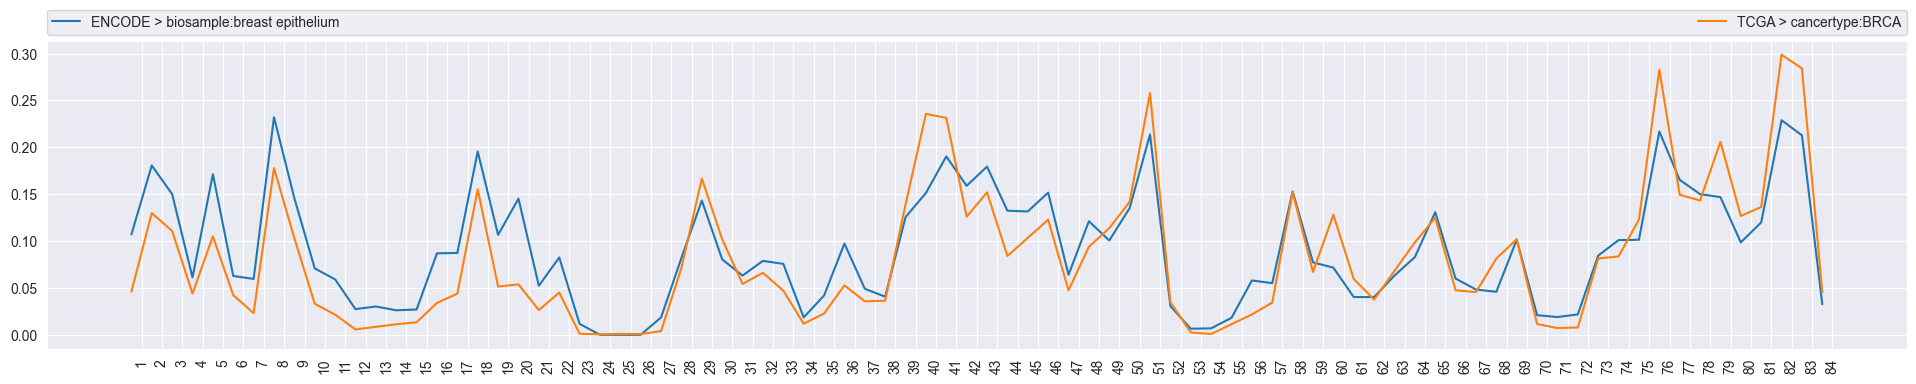

In [107]:
ca.pl.match_layers(ind.chr, ['ENCODE', 'TCGA'], 
                   groups={'ENCODE':{'biosample':'breast epithelium'}, 'TCGA':{'cancertype':'BRCA'}}, 
                   chrom='chr17', 
                   qnormalize=False, normal_y=True)

In [135]:
nix = nf['cancertype:BRCA']['index']

In [119]:
eix = ef['biosample:breast epithelium']['index']

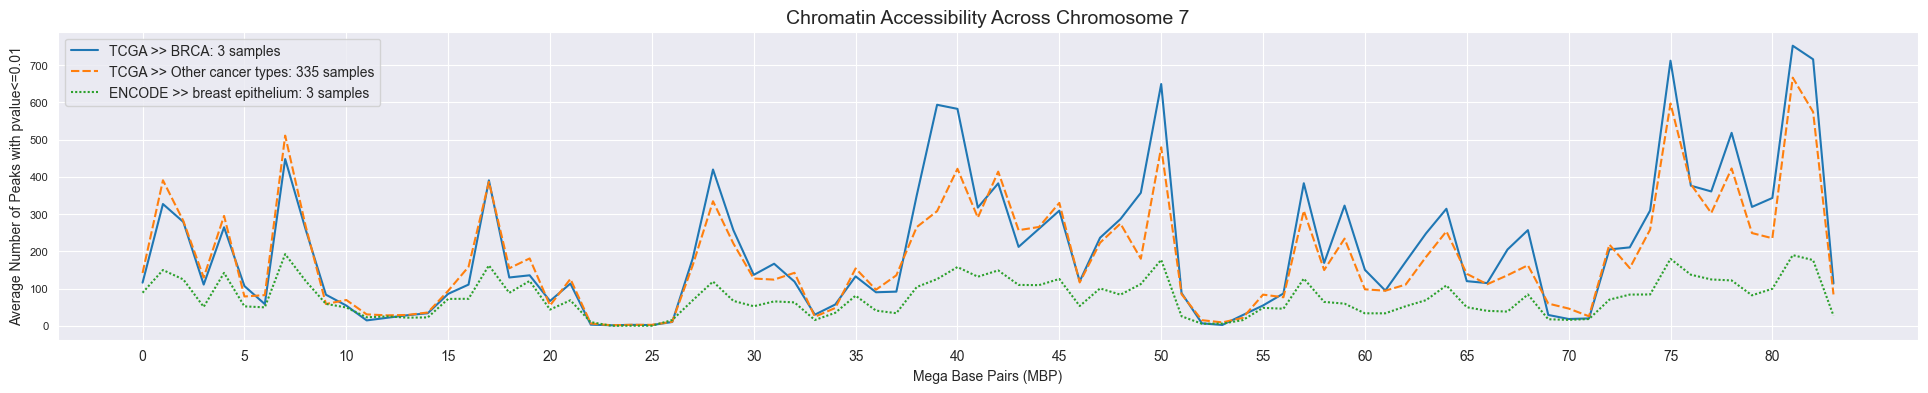

In [116]:
f = ind.chr.get_layer('TCGA', groups={'cancertype':'BRCA'}, chrom='chr17')
d = f['cancertype:BRCA']['data']
nf = ind.chr.get_layer('TCGA', groups={'cancertype':'BRCA'}, chrom='chr17', reverse_filter=True)
nd = nf['cancertype:BRCA']['data']
ef = ind.chr.get_layer('ENCODE', groups={'biosample':'breast epithelium'}, chrom='chr17')
ed = ef['biosample:breast epithelium']['data']

df = pd.DataFrame(np.vstack([d.mean(0).T, nd.mean(0).T, ed.mean(0).T]), index=[f'TCGA >> BRCA: {ed.shape[0]} samples', f'TCGA >> Other cancer types: {nd.shape[0]} samples', f'ENCODE >> breast epithelium: {ne.shape[0]} samples']).T
plt.figure(figsize=(24, 4))
plt.title('Chromatin Accessibility Across Chromosome 7', fontsize=14)
plt.xlabel('Mega Base Pairs (MBP)')
plt.ylabel('Average Number of Peaks with pvalue<=0.01')
plt.xticks(np.arange(0, d.shape[1], 5))
plt.yticks(fontsize=8)
sns.lineplot(df)
plt.savefig('BRCA_atac_TCGA;ENCODE_chr7.png', bbox_inches='tight')
plt.show()

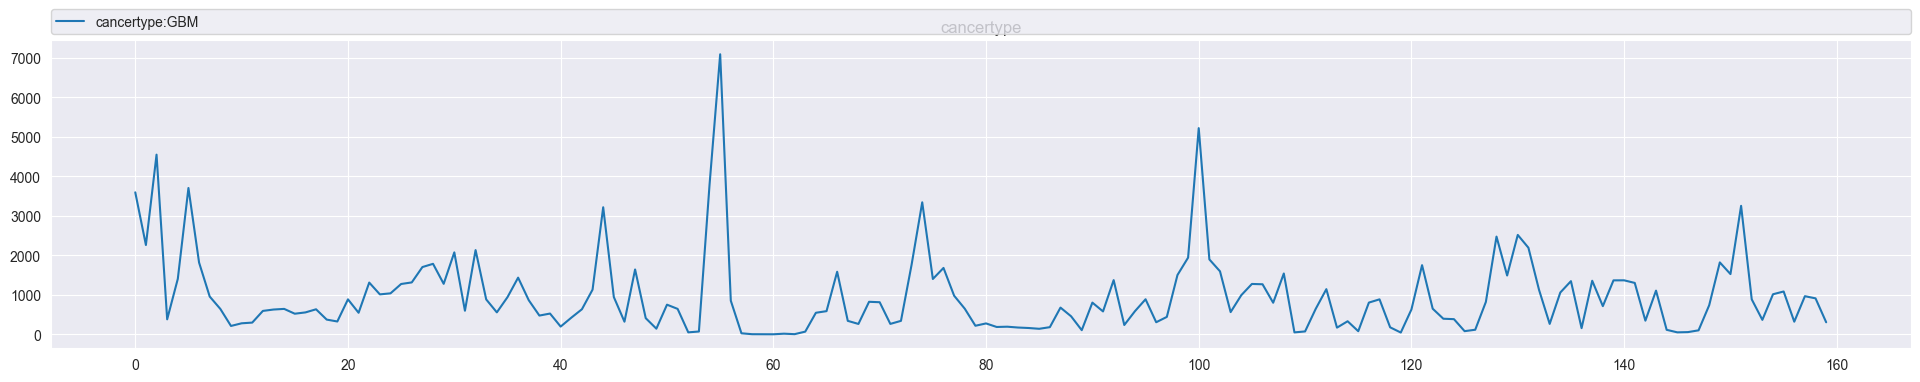

In [112]:
ca.pl.plot_layer(ind.chr, 'TCGA', groups={'cancertype':'GBM'}, chrom='chr7', qnormalize=False, normal_y=False)

In [120]:
ind.add_layer("CNVAR", input=parent_dir+'/data/CNVAR/segments/beds', feature_type='signal', resolutions=[1e06, 1e07],)
cnv_meta = pd.read_csv(parent_dir+"/data/CNVAR/summary.ascatv3TCGA.penalty70.hg38.tsv", sep='\t')
ind.chr.add_filter('Cancertype', Cnv_cancertype, ['CNVAR'])

loading files from: /Users/mossishahi/Code/lupien/IntData//data/CNVAR/segments/beds


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:24<00:00,  3.50s/it]


In [ ]:
ind.chr.add_filter('cancertype', Cnv_cancertype, ['ENCODE'])

In [ ]:
cnv_meta = pd.read_csv(parent_dir+"/data/CNVAR/summary.ascatv3TCGA.penalty70.hg38.tsv", sep='\t')
ind.chr.add_filter('Cancertype', Cnv_cancertype, ['CNVAR'])

In [11]:
encode_meta = pd.read_csv('/Users/mossishahi/Code/lupien/IntData/data/encode/metadata.tsv', sep='\t')

In [34]:
files = [i.split('.')[0] for i in os.listdir('/Users/mossishahi/Code/lupien/IntData/data/Encode_atac/all_bed_files')]

In [70]:
encode_meta = encode_meta[encode_meta['File accession'].apply(lambda x: x in files)]

In [58]:
CANCER_TYPE = 'TCGA-LUAD'
feature_columns = tcga_met[tcga_met[' Project']==CANCER_TYPE]['File Name'].apply(lambda x: np.where([x.split('_')[0].split('-')[-1] in i for i in tcga.columns])[0][0]).values
ind.add_layer(CANCER_TYPE, '/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', feature_columns=feature_columns, feature_type='signal', header=True, resolution=RESOLUTION)

Processing file: 100%|█████████▉| 14.9G/14.9G [04:09<00:00, 59.7MB/s]


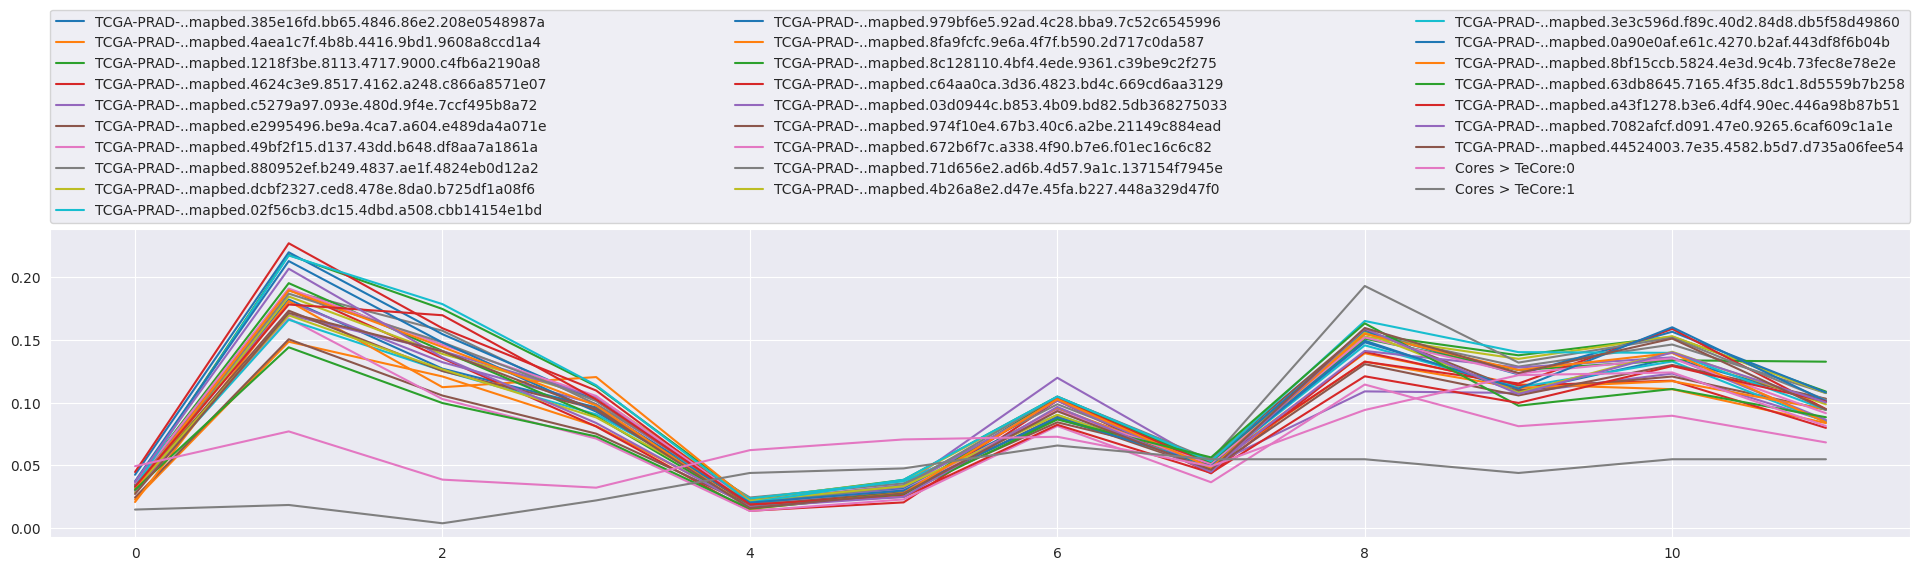

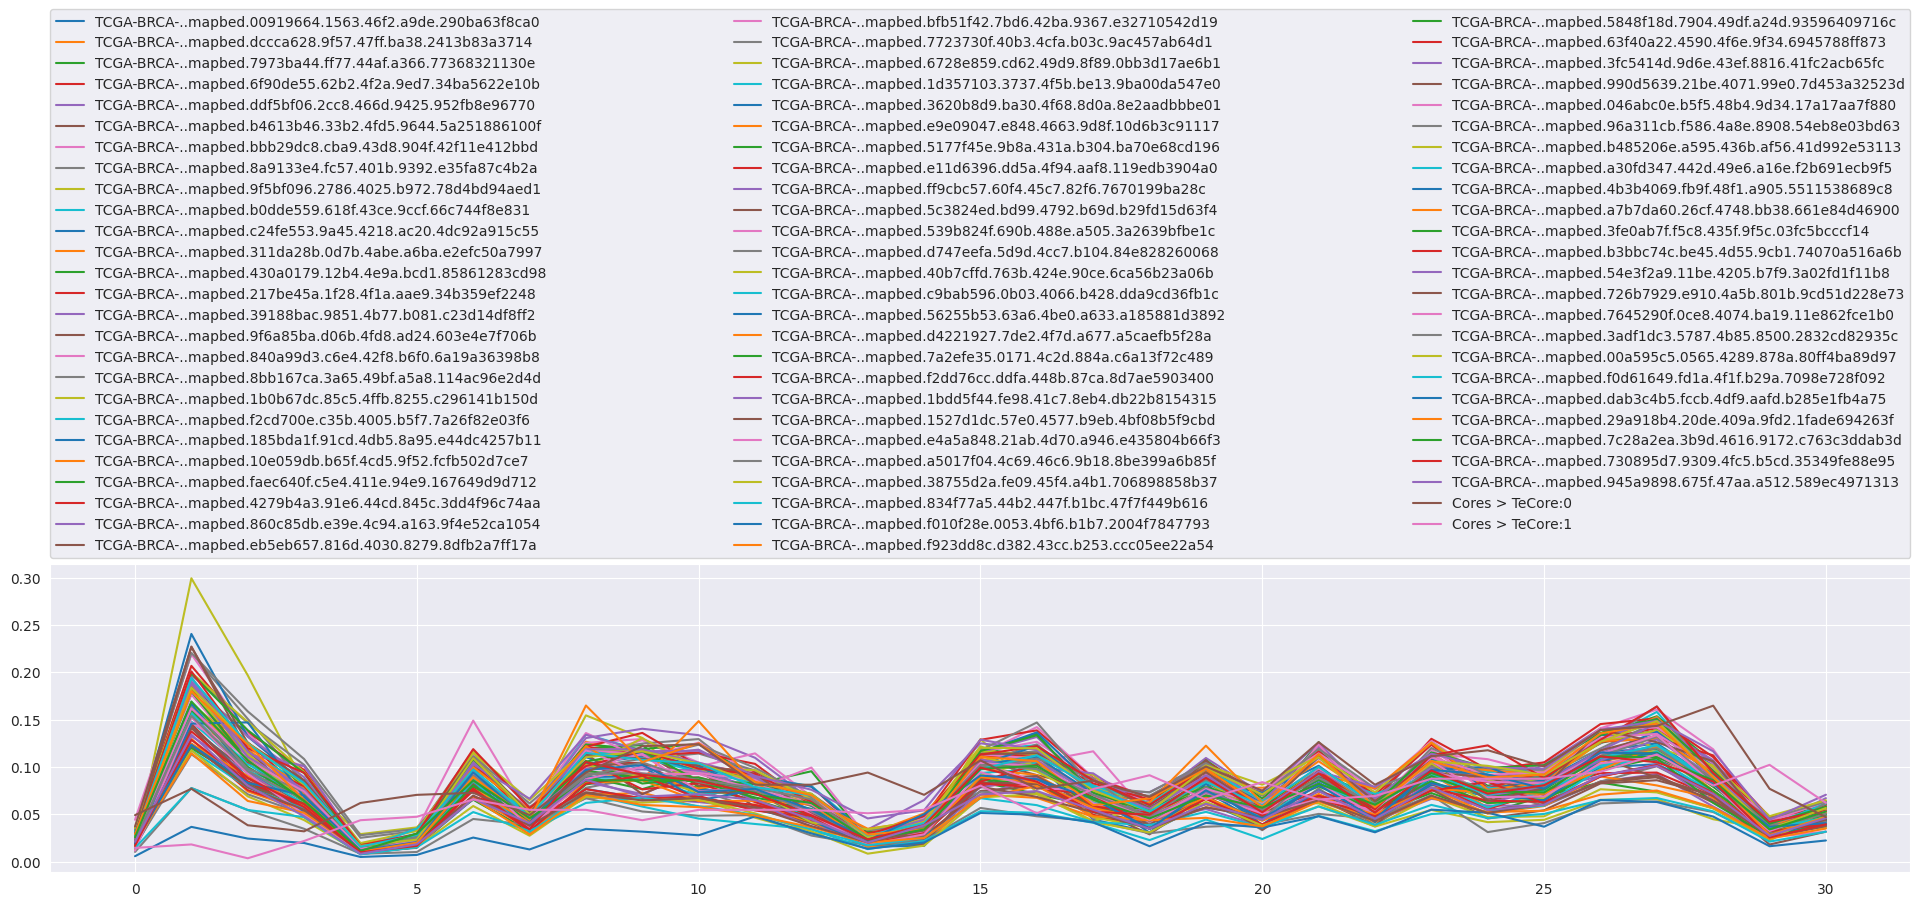

In [56]:
CHR = 'chr1'
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-PRAD')]+['Cores'],groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06, reduce_dim = True)
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-BRCA')]+['Cores'], groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06, reduce_dim = True)

In [62]:
CHR = 'chrX'
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-PRAD')]+['Cores'],groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e07)
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-LUAD')]+['Cores'], groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e07)

KeyError: 'TCGA-PRAD-..mapbed.385e16fd.bb65.4846.86e2.208e0548987a'

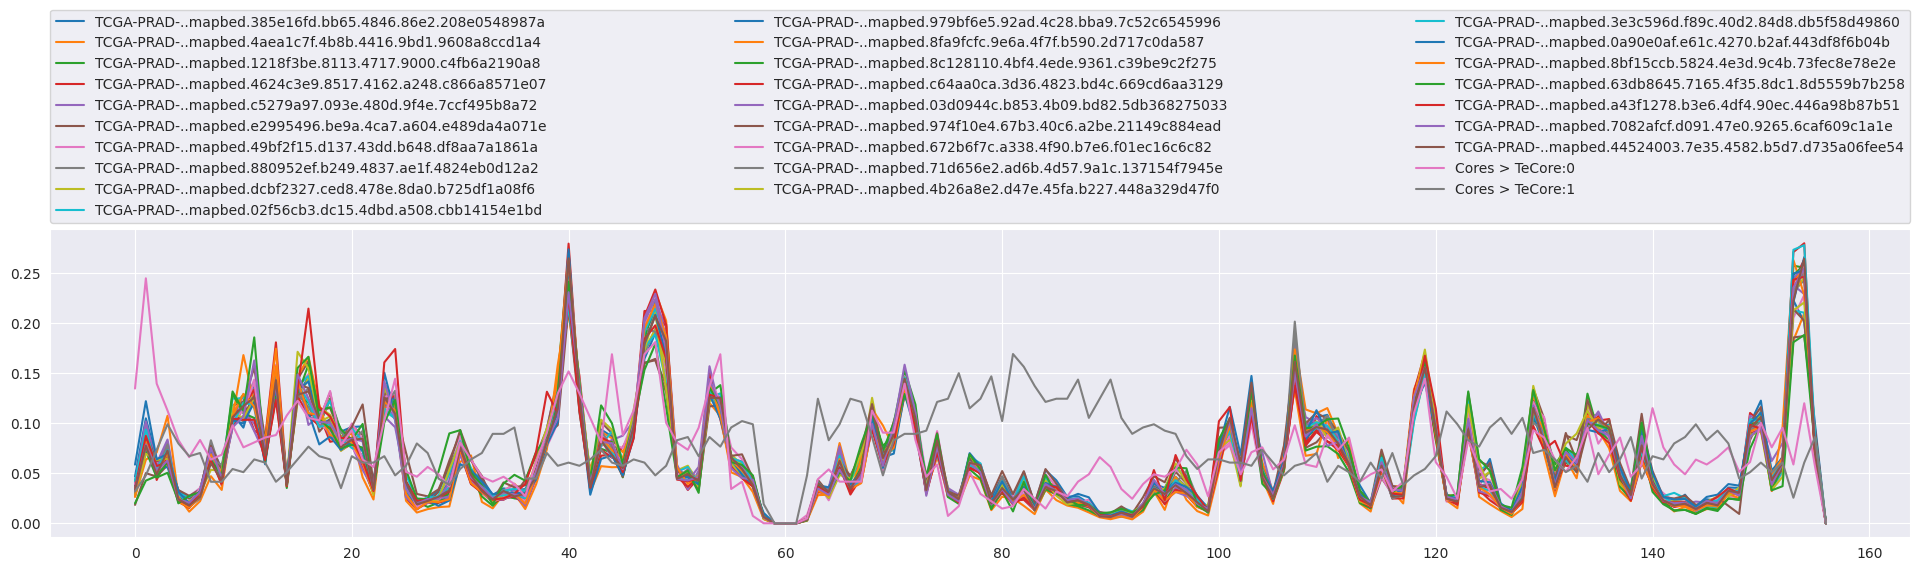

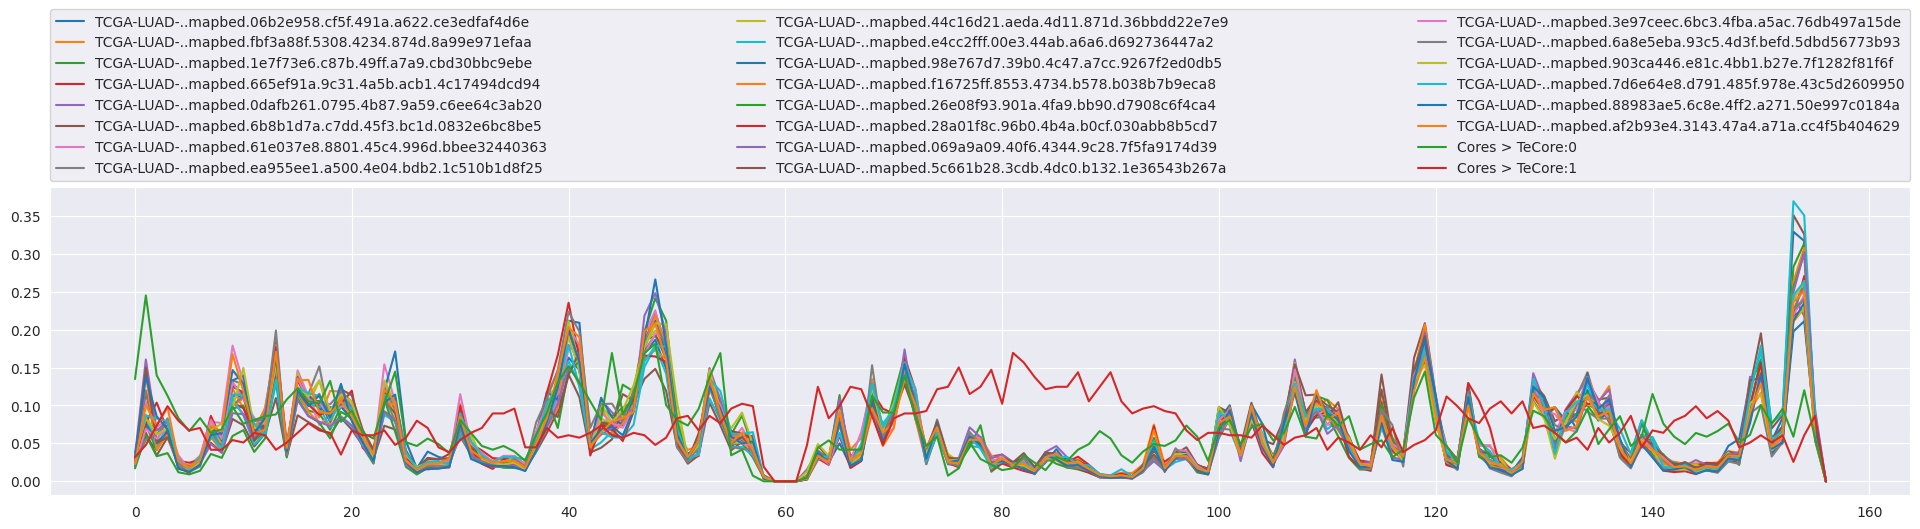

In [61]:
CHR = 'chrX'
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-PRAD')]+['Cores'],groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06)
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-LUAD')]+['Cores'], groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06)

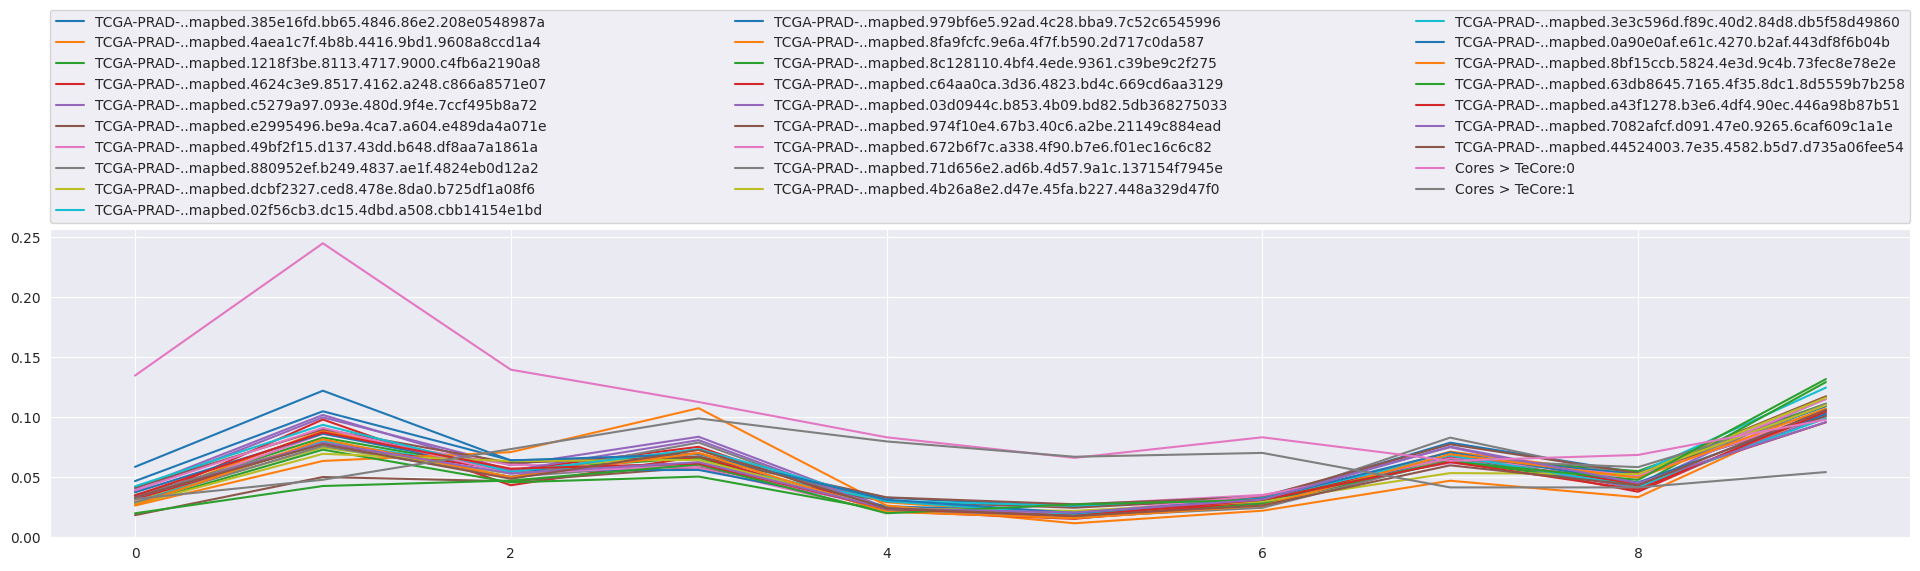

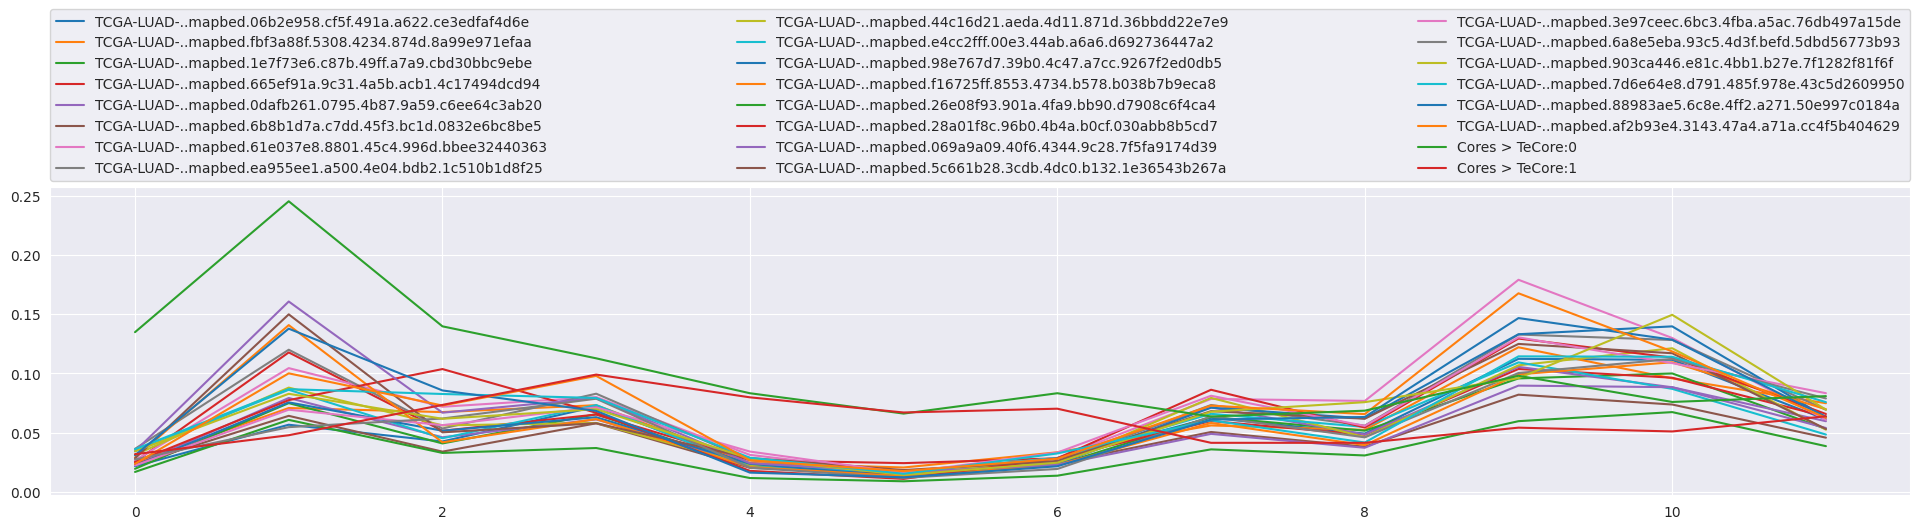

In [59]:
CHR = 'chrX'
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-PRAD')]+['Cores'],groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06, reduce_dim = True)
ca.pl.match_layers(ind.chr, [i for i in ind.chr.layers[1e06].keys() if i.startswith('TCGA-LUAD')]+['Cores'], groups={'Cores':{'TeCore':[0, 1]}}, chr=CHR, resolution=1e06, reduce_dim = True)

## Add Filters

In [39]:
ind.genome.differentiate_layers(['TEs', 'Cores'], scale=True, resolution='chr')

In [47]:
outliers = ca.al.identify_outliers(ind.genome.layers['chr']['Cores-TEs'], axis=0, signed=True, return_value=True)

In [48]:
test_res = outliers['total']
index = ind.genome.layers['chr']['Cores-TEs']['index']

In [49]:
def CTeCore_filter(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    for chr in range(1, 25):
        idx = kwargs.get('index')[kwargs.get('test_res')[:, chr-1]>=kwargs.get('majority', 3)]
        conditions[chr] = np.array([int(i in idx) for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [50]:
def GTeCore_filter(genome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {0:'TEs with No Significant Difference between #Cores and #Elements in this Chromosome', 1:'TEs with Significant Difference between #Cores and #Elements in this Chromosome'}
    for chr in range(1, 25):
        idx = kwargs.get('index')[kwargs.get('test_res')[:, chr-1]>=kwargs.get('majority', 3)]
        conditions[chr] = np.array([int(i in idx) for i in genome_layer['index']])
        annotations[chr] = ann
    return conditions, annotations

In [51]:
ind.chr.add_filter('TeCore', CTeCore_filter, layers = ['TEs', 'Cores'], index=index, test_res=test_res, resolution=1e06)
ind.genome.add_filter('TeCore', GTeCore_filter, layers = ['TEs', 'Cores', 'Cores-TEs'], index=index, test_res=test_res, resolution=1e06)

In [55]:
ind.add_layer('Encode', input='/cluster/projects/lupiengroup/People/mossi/data/encode/bedfiles', feature_columns=[6], file_format='gz', feature_type='signal')

loading files from: /cluster/projects/lupiengroup/People/mossi/data/encode/bedfiles


100%|██████████| 460/460 [07:36<00:00,  1.01it/s]


In [63]:
RESOLUTION = 1e07

In [64]:
ind.add_layer("TEs", input='/cluster/home/t124771uhn/data/V2-TEs/non_olap/', resolution=RESOLUTION)

loading files from: /cluster/home/t124771uhn/data/V2-TEs/non_olap/


100%|██████████| 975/975 [00:24<00:00, 39.03it/s]


### Number of CREAM Cores

In [65]:
ind.add_layer("Cores", input='/cluster/home/t124771uhn/data/V2-TEs/non_olap/cores1000/', resolution=RESOLUTION)

loading files from: /cluster/home/t124771uhn/data/V2-TEs/non_olap/cores1000/


100%|██████████| 455/455 [00:00<00:00, 477.39it/s]


In [66]:
tcga = pd.read_csv('/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', nrows=1, sep='\t')
tcga_met = pd.read_csv('/cluster/home/t124771uhn/data/TCGA_ATAC/GDC_metadata.tsv', sep='\t')

In [67]:
tcga_met[' Project'].unique()

array(['TCGA-LUSC', 'TCGA-STAD', 'TCGA-LUAD', 'TCGA-PCPG', 'TCGA-COAD',
       'TCGA-KIRP', 'TCGA-BLCA', 'TCGA-HNSC', 'TCGA-ESCA', 'TCGA-PRAD',
       'TCGA-BRCA', 'TCGA-MESO', 'TCGA-TGCT', 'TCGA-UCEC', 'TCGA-SKCM',
       'TCGA-LIHC', 'TCGA-THCA', 'TCGA-LGG', 'TCGA-GBM', 'TCGA-KIRC',
       'TCGA-CHOL', 'TCGA-CESC', 'TCGA-ACC'], dtype=object)

In [68]:
# You have to select the cancer type then the samples from that cancer type will be loaded into a single Layer
CANCER_TYPE = 'TCGA-PRAD'

In [69]:
feature_columns = tcga_met[tcga_met[' Project']==CANCER_TYPE]['File Name'].apply(lambda x: np.where([x.split('_')[0].split('-')[-1] in i for i in tcga.columns])[0][0]).values
ind.add_layer(CANCER_TYPE, '/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', feature_columns=feature_columns, feature_type='signal', header=True, resolution=RESOLUTION)

Processing file: 100%|█████████▉| 14.9G/14.9G [03:45<00:00, 66.0MB/s]


In [70]:
CANCER_TYPE = 'TCGA-BRCA'
feature_columns = tcga_met[tcga_met[' Project']==CANCER_TYPE]['File Name'].apply(lambda x: np.where([x.split('_')[0].split('-')[-1] in i for i in tcga.columns])[0][0]).values
ind.add_layer(CANCER_TYPE, '/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', feature_columns=feature_columns, feature_type='signal', header=True, resolution=RESOLUTION)

Processing file: 100%|█████████▉| 14.9G/14.9G [09:09<00:00, 27.1MB/s]


In [71]:
CANCER_TYPE = 'TCGA-LUAD'
feature_columns = tcga_met[tcga_met[' Project']==CANCER_TYPE]['File Name'].apply(lambda x: np.where([x.split('_')[0].split('-')[-1] in i for i in tcga.columns])[0][0]).values
ind.add_layer(CANCER_TYPE, '/cluster/home/t124771uhn/data/TCGA_ATAC/normalized_consensus_TCGA_signal.counts', feature_columns=feature_columns, feature_type='signal', header=True, resolution=RESOLUTION)

Processing file: 100%|█████████▉| 14.9G/14.9G [03:18<00:00, 75.1MB/s]


In [91]:
ind.chr.layers[1e06].keys()

odict_keys(['TEs', 'Cores', 'TCGA'])

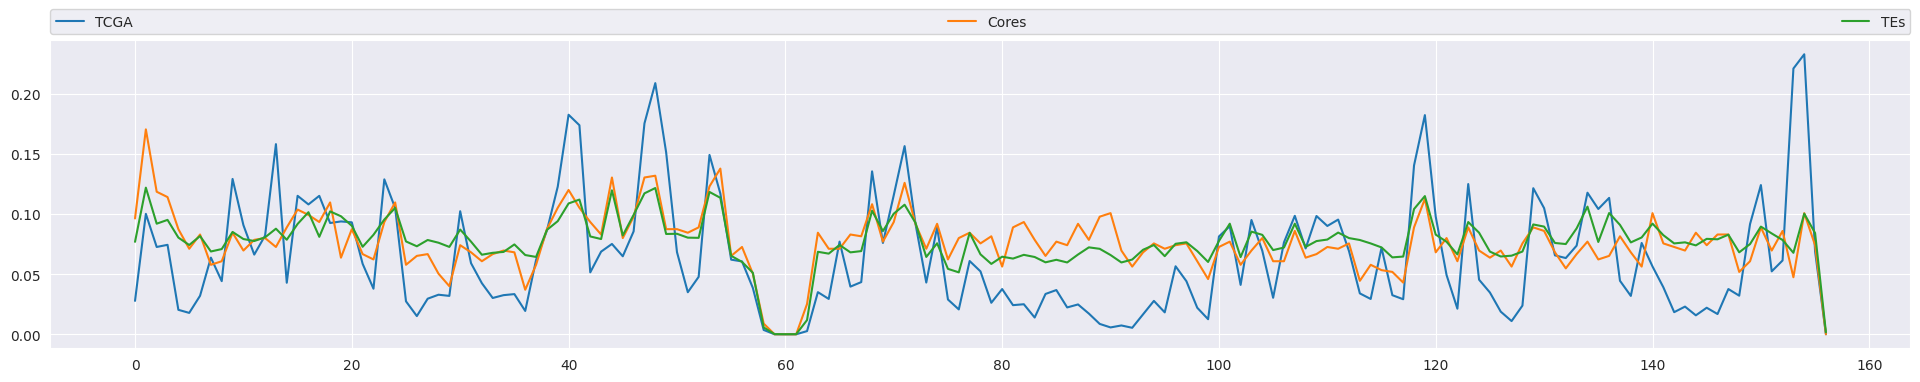

In [94]:
ca.pl.match_layers(ind.chr, ['TCGA', 'Cores', 'TEs'], chr=23, resolution=1e06, reduce_dim=True)